# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [2]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [3]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [5]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/128104/1272-128104-0000.flac"

In [6]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [7]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [8]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

In [9]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

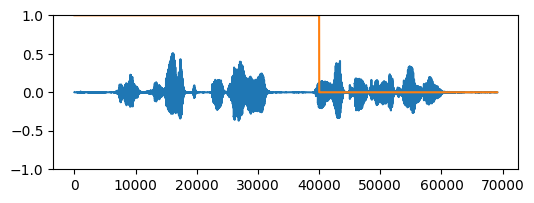

In [10]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [11]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [12]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [13]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [14]:
inputs = inputs2   # use the batch

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [15]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [16]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)

In [17]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"

In [18]:
hf_model = SpeechT5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [19]:
hf_model.eval()

SpeechT5ForConditionalGeneration(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5SpeechEncoder(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
    

In [20]:
# Normally loading should work OK for class `SpeechT5Model` too. 
# However, since that doesn't have the same encoder and decoder (not wrapped)
# the weights have the wrong paths.
# hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

In [21]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [22]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

tuple

In [23]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [24]:
# list(hf_outputs.keys())

In [25]:
# hf_outputs["extract_features"].shape

In [26]:
# hf_outputs["extract_features"]

In [27]:
# hf_outputs["hidden_states"].shape

In [28]:
# hf_outputs["hidden_states"]

In [29]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([2, 401, 768]), torch.Size([2, 401])]

In [30]:
hf_outputs[0]

tensor([[[ 7.9166, -2.5645, 13.4132,  ...,  0.9873,  2.0047,  0.4048],
         [ 9.2179, -2.3052, 14.9278,  ..., -0.3634,  1.1286,  0.5824],
         [-3.0500,  4.4579, -1.0452,  ...,  0.5873, -0.4209,  2.4890],
         ...,
         [-0.6976, -1.4458, -1.5213,  ..., -0.2206,  0.3340,  0.1747],
         [-0.7179, -1.4457, -1.5213,  ..., -0.2218,  0.3617,  0.1673],
         [-0.7312, -1.4713, -1.5220,  ..., -0.1875,  0.2293, -0.0329]],

        [[ 1.4333, -1.8173,  0.9116,  ...,  0.7428, -0.3993,  1.0221],
         [ 0.5649, -2.0062,  0.0223,  ...,  0.6641,  0.0982,  1.4818],
         [-0.2755, -2.7482, -0.7642,  ...,  0.4799,  0.2442,  1.1358],
         ...,
         [ 0.1279, -1.4121, -0.8527,  ...,  0.5464, -0.2747,  0.8503],
         [ 0.0668, -1.0637, -1.1532,  ...,  0.5738, -0.1160,  1.2345],
         [ 0.5193, -1.9056, -0.5770,  ...,  0.4975,  0.1598,  1.6285]]])

In [31]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[1]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [32]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [33]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [34]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [35]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [36]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [37]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [38]:
#list(checkpoint["model"].keys())

In [39]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [40]:
# orig_model.decoder.layers[0].encoder_attn

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [41]:
source = inputs["input_values"]
source.shape

torch.Size([2, 128632])

In [42]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [43]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False]])

In [44]:
# This doesn't work on the original model
#padding_mask = None

In [45]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [46]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [47]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([2, 401, 768]), torch.Size([2, 401]))

In [48]:
encoder_input

tensor([[[ 7.9166, -2.5645, 13.4132,  ...,  0.9873,  2.0047,  0.4048],
         [ 9.2179, -2.3052, 14.9278,  ..., -0.3634,  1.1286,  0.5824],
         [-3.0500,  4.4579, -1.0452,  ...,  0.5873, -0.4209,  2.4890],
         ...,
         [-0.6976, -1.4458, -1.5213,  ..., -0.2206,  0.3340,  0.1747],
         [-0.7179, -1.4457, -1.5213,  ..., -0.2218,  0.3617,  0.1673],
         [-0.7312, -1.4713, -1.5220,  ..., -0.1875,  0.2293, -0.0329]],

        [[ 1.4333, -1.8173,  0.9116,  ...,  0.7428, -0.3993,  1.0221],
         [ 0.5649, -2.0062,  0.0223,  ...,  0.6641,  0.0982,  1.4818],
         [-0.2755, -2.7482, -0.7642,  ...,  0.4799,  0.2442,  1.1358],
         ...,
         [ 0.1279, -1.4121, -0.8527,  ...,  0.5464, -0.2747,  0.8503],
         [ 0.0668, -1.0637, -1.1532,  ...,  0.5738, -0.1160,  1.2345],
         [ 0.5193, -1.9056, -0.5770,  ...,  0.4975,  0.1598,  1.6285]]])

In [49]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [50]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(1.0000)

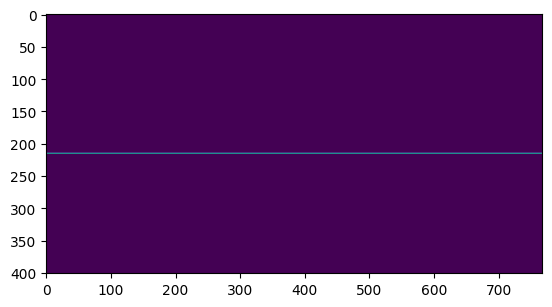

In [51]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

The line that is different is where the padding mask goes from 1 to 0; the original model handles this a little different than we do.

In [52]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [53]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [54]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [55]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [56]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([401, 2, 768])
encoder_padding_mask shape torch.Size([2, 401])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([401, 2, 81])


In [57]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.2958, -0.1868, -0.5756,  ...,  0.3251, -0.8031,  0.2546],
         [-0.3142, -0.1687, -0.6311,  ...,  0.2724, -0.8867,  0.1609],
         [-0.3856, -0.1547, -0.7009,  ...,  0.2810, -0.7849,  0.0047],
         ...,
         [-0.2996, -0.2572, -0.2176,  ..., -0.0371, -0.3114,  0.2447],
         [-0.2781, -0.2788, -0.1919,  ...,  0.1189, -0.2927,  0.1661],
         [-0.2763, -0.2893, -0.2026,  ...,  0.1521, -0.2810,  0.1230]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]])

In [58]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.7003,  -9.8230,  -9.8102,  ...,  -9.7416,  -9.6264,  12.8432],
         [-10.0260, -10.0707, -10.1447,  ..., -10.0677,  -9.9987,  13.4569],
         [-11.1218, -11.1262, -11.1428,  ..., -11.1431, -11.0712,  14.8944],
         ...,
         [-11.9023, -12.3399, -12.1404,  ..., -12.2093, -11.7069,   9.8889],
         [-10.3436, -10.7269, -10.5387,  ..., -10.5104, -10.1166,   8.9614],
         [ -9.7999, -10.1612,  -9.9818,  ...,  -9.9216,  -9.5704,   8.4546]],

        [[ -9.9849, -10.1272, -10.0026,  ..., -10.0058,  -9.7552,  12.7793],
         [-10.4426, -10.5391, -10.4868,  ..., -10.5314, -10.2572,  13.7857],
         [-12.3113, -12.4078, -12.2937,  ..., -12.4932, -12.1741,  15.2556],
         ...,
         [ -9.1622,  -9.3113,  -9.2084,  ...,  -9.3590,  -9.0228,  11.5350],
         [ -9.9882, -10.2963,  -9.9973,  ..., -10.0581,  -9.7548,  11.7940],
         [-10.3344, -10.8017, -10.4995,  ..., -10.4289,  -9.9483,  10.9756]]])

In [59]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [60]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=hf_encoder_attention_mask,
#          input_values=inputs.input_values,
#          attention_mask=inputs.attention_mask,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [61]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.2958, -0.1868, -0.5756,  ...,  0.3251, -0.8031,  0.2546],
         [-0.3142, -0.1687, -0.6311,  ...,  0.2724, -0.8867,  0.1609],
         [-0.3856, -0.1547, -0.7009,  ...,  0.2810, -0.7849,  0.0047],
         ...,
         [-0.2996, -0.2572, -0.2176,  ..., -0.0371, -0.3114,  0.2447],
         [-0.2781, -0.2788, -0.1919,  ...,  0.1189, -0.2927,  0.1661],
         [-0.2763, -0.2893, -0.2026,  ...,  0.1521, -0.2810,  0.1230]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]]), hidden_states=None, attentions=None)

In [62]:
list(hf_outputs.keys())

['last_hidden_state']

In [63]:
hf_outputs["last_hidden_state"].shape

torch.Size([2, 401, 768])

In [64]:
hf_outputs["last_hidden_state"]

tensor([[[-0.2958, -0.1868, -0.5756,  ...,  0.3251, -0.8031,  0.2546],
         [-0.3142, -0.1687, -0.6311,  ...,  0.2724, -0.8867,  0.1609],
         [-0.3856, -0.1547, -0.7009,  ...,  0.2810, -0.7849,  0.0047],
         ...,
         [-0.2996, -0.2572, -0.2176,  ..., -0.0371, -0.3114,  0.2447],
         [-0.2781, -0.2788, -0.1919,  ...,  0.1189, -0.2927,  0.1661],
         [-0.2763, -0.2893, -0.2026,  ...,  0.1521, -0.2810,  0.1230]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]])

In [65]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(2.3246e-06)

## Verify CTC model

This model only needs the encoder portion.

This uses the same checkpoint as before: `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Run the following to convert, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task ctc \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [69]:
# hf_model_ctc = SpeechT5ForCTC(config)

In [66]:
model_checkpoint_ctc = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc"
hf_model_ctc = SpeechT5ForCTC.from_pretrained(model_checkpoint_ctc)

In [67]:
# Not sure if this should work, since SpeechT5ForCTC does not have a speecht5 property...
#hf_model_ctc = SpeechT5Model.from_pretrained(model_checkpoint_ctc)

In [68]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model_ctc(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model_ctc(input_values=inputs["input_values"])

type(hf_outputs)

transformers.modeling_outputs.CausalLMOutput

In [69]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(9.5367e-06)

In [70]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [71]:
probs

tensor([[80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4, 46, 80, 80, 16, 80, 80, 12, 12,  6,  6,  6, 80, 80, 80,
         80,  4,  4,  4,  6,  6, 11, 11, 13, 13, 13, 80, 16, 16, 80, 80, 80, 80,
         12, 12,  6,  6, 80, 80, 80, 80, 80, 80, 80, 80,  4,  4,  4, 80, 80,  7,
          9, 14, 14,  4,  4, 80, 24, 80, 80, 80, 80,  5, 13, 13, 13, 13, 13, 13,
         80, 22, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4, 80,  7,  7,  9, 14,
         14, 80,  4,  4,  4, 27, 80, 80, 10, 80, 17, 17,  6,  6,  6,  8, 13, 13,
         13, 22, 80, 80, 80,  4,  4,  6,  8,  8, 80,  4,  6,  6, 11,  5,  5,  4,
         12, 12, 80,  6,  6, 13, 13, 80, 80,  8, 80,  9,  9, 80, 21, 21, 80, 80,
          5, 13, 13, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80,

In [72]:
# print(tgt_dict.string(probs[0]))

In [74]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))
    print("")

                jussttt   tthhrrruusstt   andd  perrrrrry       aandd   vicctttorrry  too tthee ssttrronnggerr

       sseelllff  ddesssttrruuucct  will ccoommennce in  ffiivee       ffoouurrr      tthhrrreeeee      tttwwoo        onnee  annd   a  hhaaalllff       oonnee  annd  aa  qquuuaarrterr       oonne  annd  a  littttlee bbiitt



Calculate loss:

In [ ]:
with torch.no_grad():
     hf_outputs = hf_model_ctc(
         **inputs, 
         labels=torch.tensor(
           [[ 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13, ]]
         ),
         output_hidden_states=True,
         return_dict=True,
     )

In [ ]:
hf_outputs.loss

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [76]:
batch_size = inputs.input_values.size(0)
beam_size = 5

In [77]:
tokens = torch.tensor([2, 4, 46, 16, 12, 16] * beam_size * batch_size).reshape(beam_size * batch_size, -1)
tokens.shape

torch.Size([10, 6])

In [78]:
# This one has padding (token_id = 1)
# The results will be different with the HF implementation because
# we don't set the attention_mask to 0 for padding tokens
# tokens = torch.tensor([2, 4, 46, 16, 1, 12] * beam_size * batch_size).reshape(beam_size * batch_size, -1)

In [79]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state=None)

In [80]:
# This returns a sequence length of 1
# with torch.no_grad():
#     prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state={})

In [81]:
# Note: misleading name; these are not the actual tokens but their embeddings!
prev_output_tokens.shape

torch.Size([10, 6, 768])

In [82]:
tgt_mask

In [83]:
incremental_state

In [84]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_ids=tokens,
#          attention_mask=hf_encoder_attention_mask,
#          attention_mask=inputs.attention_mask,
#          past_key_values=[(torch.ones(5, 1, 1), torch.ones(5, 1, 1))],
     )

type(hf_outputs)

tuple

In [85]:
token_embeds_hf, decoder_attention_mask = hf_outputs

In [86]:
token_embeds_hf.shape

torch.Size([10, 6, 768])

In [87]:
torch.max(torch.abs(prev_output_tokens - token_embeds_hf))

tensor(0.)

In [88]:
decoder_attention_mask

## Verify Transformer decoder output

In [89]:
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [90]:
prev_output_tokens

tensor([[[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
  

In [91]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [92]:
decoder_output.shape

torch.Size([10, 6, 768])

In [93]:
decoder_output

tensor([[[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
         [-0.0907, -0.0461, -0.4361,  ...,  0.1990, -0.2789,  0.1868],
         [ 0.8854, -0.3577, -1.4784,  ...,  0.1855,  0.1554, -0.3780],
         [ 0.5764, -0.4550, -0.2252,  ..., -0.4585, -0.1639, -0.5217],
         [ 0.7981, -0.3895, -0.8105,  ...,  0.1244,  0.2380, -0.2574]],

        [[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
         [-0.0907, -0.0461, -0.4361,  ...,  0.1990, -0.2789,  0.1868],
         [ 0.8854, -0.3577, -1.4784,  ...,  0.1855,  0.1554, -0.3780],
         [ 0.5764, -0.4550, -0.2252,  ..., -0.4585, -0.1639, -0.5217],
         [ 0.7981, -0.3895, -0.8105,  ...,  0.1244,  0.2380, -0.2574]],

        [[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
  

In [94]:
#[x.shape for x in extra["attn"]]

In [95]:
#[x.shape for x in extra["inner_states"]]

In [96]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_outs["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [97]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [98]:
hf_outputs["last_hidden_state"].shape

torch.Size([10, 6, 768])

In [99]:
hf_outputs["last_hidden_state"]

tensor([[[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
         [-0.0907, -0.0461, -0.4361,  ...,  0.1990, -0.2789,  0.1868],
         [ 0.8854, -0.3577, -1.4784,  ...,  0.1855,  0.1554, -0.3780],
         [ 0.5764, -0.4550, -0.2252,  ..., -0.4585, -0.1639, -0.5217],
         [ 0.7981, -0.3895, -0.8105,  ...,  0.1244,  0.2380, -0.2574]],

        [[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
         [-0.0907, -0.0461, -0.4361,  ...,  0.1990, -0.2789,  0.1868],
         [ 0.8854, -0.3577, -1.4784,  ...,  0.1855,  0.1554, -0.3780],
         [ 0.5764, -0.4550, -0.2252,  ..., -0.4585, -0.1639, -0.5217],
         [ 0.7981, -0.3895, -0.8105,  ...,  0.1244,  0.2380, -0.2574]],

        [[-0.5030, -0.3445, -0.2332,  ..., -0.2787, -0.4045,  0.0066],
         [-0.2348, -0.0063, -0.7550,  ..., -0.1974, -0.6192, -0.0027],
  

In [100]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(1.4305e-06)

## Verify text decoder postnet output

In [101]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [102]:
lprobs.shape

torch.Size([10, 6, 81])

In [103]:
lprobs[0]

tensor([[-2.1653e+01, -2.1903e+01,  1.1883e+00, -2.1865e+01,  1.6534e+01,
          5.5673e-02,  3.0473e-01, -1.1260e+00, -2.9652e-01, -1.6258e+00,
         -8.2225e-02, -4.3624e-02, -1.7976e-01, -8.3170e-01, -2.3726e+00,
         -1.1654e+00, -8.4005e-01, -2.3911e+00, -9.3855e-01, -6.0906e-01,
          9.2375e-01, -6.6507e-02, -2.8258e+00, -2.1986e+01, -1.3389e+00,
          7.0116e-01, -2.1933e+01, -3.1611e+00, -2.5848e+00, -2.1882e+01,
         -2.1913e+01,  3.2156e-01, -2.2011e+01, -2.1879e+01, -2.1878e+01,
         -2.1948e+01, -2.1919e+01, -5.7559e+00, -2.1884e+01, -2.1979e+01,
         -2.1856e+01, -2.1932e+01, -2.1922e+01, -2.1933e+01, -2.1903e+01,
         -2.5441e+00, -1.3407e+00, -2.1845e+01, -2.1888e+01, -2.2011e+01,
         -2.1885e+01, -2.1964e+01, -2.1863e+01, -2.1848e+01, -2.1898e+01,
         -2.1841e+01, -2.1898e+01, -5.9434e+00, -2.1915e+01, -2.1874e+01,
         -2.1929e+01, -2.1979e+01, -2.1919e+01, -2.1892e+01, -2.1897e+01,
         -2.1925e+01, -2.1900e+01, -2.

In [104]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [105]:
lprobs_hf.shape

torch.Size([10, 6, 81])

In [106]:
lprobs_hf[0]

tensor([[-2.1653e+01, -2.1903e+01,  1.1883e+00, -2.1865e+01,  1.6534e+01,
          5.5673e-02,  3.0473e-01, -1.1260e+00, -2.9652e-01, -1.6258e+00,
         -8.2225e-02, -4.3624e-02, -1.7976e-01, -8.3170e-01, -2.3726e+00,
         -1.1654e+00, -8.4005e-01, -2.3911e+00, -9.3855e-01, -6.0906e-01,
          9.2375e-01, -6.6507e-02, -2.8258e+00, -2.1986e+01, -1.3389e+00,
          7.0116e-01, -2.1933e+01, -3.1611e+00, -2.5848e+00, -2.1882e+01,
         -2.1913e+01,  3.2156e-01, -2.2011e+01, -2.1879e+01, -2.1878e+01,
         -2.1948e+01, -2.1919e+01, -5.7559e+00, -2.1884e+01, -2.1979e+01,
         -2.1856e+01, -2.1932e+01, -2.1922e+01, -2.1933e+01, -2.1903e+01,
         -2.5441e+00, -1.3407e+00, -2.1845e+01, -2.1888e+01, -2.2011e+01,
         -2.1885e+01, -2.1964e+01, -2.1863e+01, -2.1848e+01, -2.1898e+01,
         -2.1841e+01, -2.1898e+01, -5.9434e+00, -2.1915e+01, -2.1874e+01,
         -2.1929e+01, -2.1979e+01, -2.1919e+01, -2.1892e+01, -2.1897e+01,
         -2.1925e+01, -2.1900e+01, -2.

In [107]:
torch.max(torch.abs(lprobs - lprobs_hf))

tensor(0.)

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [109]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[3, 4, 5]]),
         decoder_input_ids=torch.tensor([[3, 4, 5], [2, 2, 2]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [110]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [111]:
hf_outputs["logits"].shape

torch.Size([2, 3, 81])

Also calculate loss:

In [112]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [113]:
hf_outputs["logits"].shape

torch.Size([2, 7, 81])

In [114]:
hf_outputs["loss"]

tensor(3.4196)

Generator loop:

In [115]:
inputs.input_values.shape

torch.Size([2, 128632])

In [116]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [117]:
hf_outputs.shape

torch.Size([2, 100])

In [118]:
hf_outputs

tensor([[ 2,  4, 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13,  4, 46, 16,
         12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4, 24,  7, 13, 13,
         22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,  6,  8,  4,  6,
         11,  5,  4, 12,  6, 13,  8,  9, 21,  5],
        [ 2,  4, 12,  5, 15, 19,  4, 14,  5, 12,  6, 13, 16, 17,  6, 10,  8,  9,
          4, 17,  8, 18, 18,  5,  9, 17,  5,  4, 10,  9,  4, 19, 10, 27,  5,  4,
         19,  8, 16, 13,  4,  6, 11, 13,  5,  5,  4,  6, 20,  8,  4,  8,  9,  5,
          4,  7,  9, 14,  4,  7,  4, 11,  7, 15, 19,  4,  8,  9,  5,  4,  7,  9,
         14,  4,  7,  4, 45, 16,  7, 13,  6,  5, 13,  4,  8,  9,  5,  4,  7,  9,
         14,  4,  7,  4, 15, 10,  6,  6, 15,  5]])

In [119]:
for i in range(hf_outputs.shape[0]):
    print(tgt_dict.string(hf_outputs[i]))
    print(tokenizer.decode(tgt_dict.string(hf_outputs[i])))
    print("")

▁ j u s t ▁ t h r u s t ▁ a n d ▁ p a r r y ▁ a n d ▁ v i c t o r y ▁ t o ▁ t h e ▁ s t r o n g e r ▁ j u s t ▁ t h r u s t ▁ a n d ▁ p a r r y ▁ a n d ▁ v i c t o r y ▁ t o ▁ t h e ▁ s t r o n g e
just thrust and parry and victory to the stronger just thrust and parry and victory to the stronge

▁ s e l f ▁ d e s t r u c t i o n ▁ c o m m e n c e ▁ i n ▁ f i v e ▁ f o u r ▁ t h r e e ▁ t w o ▁ o n e ▁ a n d ▁ a ▁ h a l f ▁ o n e ▁ a n d ▁ a ▁ q u a r t e r ▁ o n e ▁ a n d ▁ a ▁ l i t t l e
self destruction commence in five four three two one and a half one and a quarter one and a little



In [244]:
[tgt_dict[x] for x in range(5)]

['<s>', '<pad>', '</s>', '<unk>', '▁']

For comparison, Speech2Text:

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

s2t_model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
s2t_processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

In [222]:
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

inputs = s2t_processor(
    ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
)
input_features = inputs.input_features
input_features.shape

/Users/matthijs/anaconda3/envs/t5/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


torch.Size([1, 584, 80])

In [223]:
# test batch
# input_features = torch.tile(input_features, dims=(2, 1, 1))
# input_features.shape

torch.Size([2, 584, 80])

In [224]:
generated_ids = s2t_model.generate(inputs=input_features)

transcription = s2t_processor.batch_decode(generated_ids)[0]
transcription

#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1
/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the 

'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

In [255]:
from transformers import Speech2TextModel

s2t_model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*** has_prefix_module True expects_prefix_module False
*** remove_prefix_from_model False add_prefix_to_model True


Test other methods:

In [30]:
# BART, Speech2Text, Wav2Vec2 don't have pruning
#hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

In [27]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [28]:
hf_model.get_output_embeddings()

Linear(in_features=768, out_features=100, bias=False)

In [25]:
hf_model.resize_token_embeddings(100)

Embedding(100, 768)

In [26]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [117]:
hf_model.freeze_feature_encoder()

In [118]:
hf_model_ctc.freeze_feature_encoder()

In [119]:
hf_model_naked.freeze_feature_encoder()